In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

from database.connection import get_db_manager
from similarity.data_preparation import DataPreparator
from similarity.feature_engineering import FeatureEngineer
from similarity.umap_reducer import UMAPReducer
from similarity.gmm_clustering import GMMClusterer
from similarity.player_similarity import PlayerSimilarity
from similarity.visualization import SimilarityVisualizer

In [2]:
TABLE_TYPE = 'domestic'
LEAGUES = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
SEASONS = ['2425', '2526']
POSITION_FILTER = 'FW'
MIN_MINUTES = 200
MAX_AGE = 35

print(f"Configuracion: {LEAGUES}")
print(f"Temporadas: {SEASONS}")
print(f"Posicion: {POSITION_FILTER}, Min minutos: {MIN_MINUTES}")

Configuracion: ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
Temporadas: ['2425', '2526']
Posicion: FW, Min minutos: 200


In [3]:
db = get_db_manager()
data_prep = DataPreparator(db_manager=db, table_type=TABLE_TYPE)

all_seasons_data = []

for season in SEASONS:
    print(f"\nCargando temporada {season}...")
    df_season = data_prep.load_players(
        leagues=LEAGUES,
        season=season,
        position_filter=POSITION_FILTER,
        min_minutes=MIN_MINUTES,
        max_age=MAX_AGE
    )
    print(f"  Jugadores cargados temporada {season}: {len(df_season)}")
    all_seasons_data.append(df_season)

df_raw = pd.concat(all_seasons_data, ignore_index=True)
print(f"\nTotal jugadores ambas temporadas: {len(df_raw)}")
print(f"Distribucion por temporada:")
print(df_raw['season'].value_counts())

# CRITICAL FIX: Actualizar df_raw en data_prep para extract_all_metrics()
data_prep.set_raw_data(df_raw)
print(f"\nDataPreparator actualizado con {len(df_raw)} jugadores combinados")

2025-11-20 14:56:48,202 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-11-20 14:56:48,342 - database.connection - INFO - Database connection successful
2025-11-20 14:56:48,345 - similarity.data_preparation - INFO - DataPreparator initialized for table type: domestic
2025-11-20 14:56:48,348 - similarity.data_preparation - INFO - Executing query for 5 leagues, season 2425



Cargando temporada 2425...


2025-11-20 14:56:48,710 - similarity.data_preparation - INFO - Loaded 526 players matching criteria
2025-11-20 14:56:48,711 - similarity.data_preparation - INFO - Executing query for 5 leagues, season 2526
2025-11-20 14:56:48,852 - similarity.data_preparation - INFO - Loaded 373 players matching criteria
2025-11-20 14:56:48,858 - similarity.data_preparation - INFO - Raw data manually set with 899 players


  Jugadores cargados temporada 2425: 526

Cargando temporada 2526...
  Jugadores cargados temporada 2526: 373

Total jugadores ambas temporadas: 899
Distribucion por temporada:
season
2425    526
2526    373
Name: count, dtype: int64

DataPreparator actualizado con 899 jugadores combinados


In [4]:
print(f"Extrayendo metricas de {len(data_prep.df_raw)} jugadores...")
df_metrics = data_prep.extract_all_metrics()
print(f"\nMetricas extraidas: {df_metrics.shape[1]} columnas")
print(f"Shape total: {df_metrics.shape}")
print(f"Jugadores en df_metrics: {len(df_metrics)}")

2025-11-20 14:56:48,874 - similarity.data_preparation - INFO - Extracting metrics from JSON columns...


Extrayendo metricas de 899 jugadores...


2025-11-20 14:56:56,875 - similarity.data_preparation - INFO - Extracted 185 FBref metrics
2025-11-20 14:56:58,064 - similarity.data_preparation - INFO - Extracted 10 Understat metrics
2025-11-20 14:56:58,109 - similarity.data_preparation - INFO - Calculated 150 FBref per90 metrics
2025-11-20 14:56:58,130 - similarity.data_preparation - INFO - Final DataFrame: 899 players, 359 total columns



Metricas extraidas: 359 columnas
Shape total: (899, 359)
Jugadores en df_metrics: 899


In [5]:
print(f"Manejando valores faltantes en {len(data_prep.df_clean)} jugadores...")
df_clean = data_prep.handle_missing_values(
    strategy='median_by_position',
    max_missing_pct=0.6  # Menos agresivo: permite columnas con hasta 60% missing
)
print(f"\nDatos limpios: {df_clean.shape}")
print(f"Jugadores: {len(df_clean)}")

# Verificar columnas numericas disponibles
metadata_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']
numeric_cols = [col for col in df_clean.columns if col not in metadata_cols]
print(f"Columnas numericas disponibles: {len(numeric_cols)}")

2025-11-20 14:56:58,155 - similarity.data_preparation - INFO - Handling missing values with strategy: median_by_position
2025-11-20 14:56:58,158 - similarity.data_preparation - INFO - Input shape: (899, 359) (899 rows, 353 numeric cols)
2025-11-20 14:56:58,169 - similarity.data_preparation - WARNING - Removed 67 columns with >60.0% missing
2025-11-20 14:56:58,172 - similarity.data_preparation - INFO - Numeric columns remaining: 286
2025-11-20 14:56:58,221 - similarity.data_preparation - INFO - Output shape: (899, 292)


Manejando valores faltantes en 899 jugadores...


2025-11-20 14:56:58,411 - similarity.data_preparation - INFO - Imputed missing values using median_by_position
2025-11-20 14:56:58,416 - similarity.data_preparation - INFO - Final missing values: 0



Datos limpios: (899, 292)
Jugadores: 899
Columnas numericas disponibles: 286


In [6]:
df_outliers = data_prep.detect_outliers(
    method='isolation_forest',
    contamination=0.05
)
print(f"Outliers detectados: {df_outliers['is_outlier'].sum()}")
print(f"Outliers %: {df_outliers['is_outlier'].sum() / len(df_outliers) * 100:.1f}%")

2025-11-20 14:56:58,436 - similarity.data_preparation - INFO - Detecting outliers using isolation_forest
2025-11-20 14:56:58,440 - similarity.data_preparation - INFO - Processing 899 players with 286 numeric features
2025-11-20 14:56:58,671 - similarity.data_preparation - INFO - Detected 45 outliers (5.0%)


Outliers detectados: 45
Outliers %: 5.0%


In [7]:
feature_eng = FeatureEngineer(position_type='FW')

df_selected = feature_eng.select_relevant_features(
    df_outliers,
    exclude_gk_metrics=True,
    min_variance=0.01
)
print(f"Features seleccionadas: {len(feature_eng.selected_features)}")

2025-11-20 14:56:58,698 - similarity.feature_engineering - INFO - FeatureEngineer initialized for position: FW
2025-11-20 14:56:58,702 - similarity.feature_engineering - INFO - Selecting relevant features...
2025-11-20 14:56:58,705 - similarity.feature_engineering - INFO - Excluded GK metrics, 284 features remaining
2025-11-20 14:56:58,707 - similarity.feature_engineering - INFO - Using 20 position-specific features for FW
2025-11-20 14:56:58,714 - similarity.feature_engineering - INFO - Removed 1 low-variance features
2025-11-20 14:56:58,721 - similarity.feature_engineering - INFO - Final feature count: 19


Features seleccionadas: 19


In [8]:
df_uncorrelated = feature_eng.remove_correlated_features(
    df_selected,
    threshold=0.95
)
print(f"Features no redundantes: {len(feature_eng.selected_features)}")

2025-11-20 14:56:58,747 - similarity.feature_engineering - INFO - Removing highly correlated features (threshold=0.95)...
2025-11-20 14:56:58,758 - similarity.feature_engineering - INFO - No highly correlated features found


Features no redundantes: 20


In [9]:
df_normalized = feature_eng.normalize_by_position(
    df_uncorrelated,
    method='standard',
    fit_per_position=True
)
print("Normalizacion completada por posicion")
print("Nota: Normalizacion valida incluso con temporada 25/26 incompleta")
print("Razon: Metricas per90 ya normalizadas por minutos jugados")

2025-11-20 14:56:58,781 - similarity.feature_engineering - INFO - Normalizing features using standard method...
2025-11-20 14:56:58,806 - similarity.feature_engineering - INFO - Normalized features by position group


Normalizacion completada por posicion
Nota: Normalizacion valida incluso con temporada 25/26 incompleta
Razon: Metricas per90 ya normalizadas por minutos jugados


In [10]:
X, metadata_df = feature_eng.prepare_for_umap(df_normalized, return_dataframe=True)
print(f"Matriz features para UMAP: {X.shape}")
print(f"Metadata shape: {metadata_df.shape}")

2025-11-20 14:56:58,825 - similarity.feature_engineering - INFO - Prepared feature matrix: (899, 20)


Matriz features para UMAP: (899, 20)
Metadata shape: (899, 7)


In [11]:
umap_reducer = UMAPReducer(
    n_components=5,
    n_neighbors=20,
    min_dist=0.0,
    metric='euclidean',
    random_state=42
)

print("Ejecutando UMAP (esto puede tardar 30-60 segundos)...")
X_umap = umap_reducer.fit_transform(X, verbose=True)
print(f"\nUMAP completado: {X_umap.shape}")

2025-11-20 14:56:58,850 - similarity.umap_reducer - INFO - UMAPReducer initialized: n_components=5, n_neighbors=20, min_dist=0.0
2025-11-20 14:56:58,854 - similarity.umap_reducer - INFO - Fitting UMAP on 899 samples, 20 features...


Ejecutando UMAP (esto puede tardar 30-60 segundos)...
UMAP(min_dist=0.0, n_components=5, n_jobs=1, n_neighbors=20, random_state=42, verbose=True)
Thu Nov 20 14:56:58 2025 Construct fuzzy simplicial set
Thu Nov 20 14:57:00 2025 Finding Nearest Neighbors
Thu Nov 20 14:57:08 2025 Finished Nearest Neighbor Search
Thu Nov 20 14:57:12 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


2025-11-20 14:57:15,845 - similarity.umap_reducer - INFO - UMAP fitting complete. Output shape: (899, 5)


Thu Nov 20 14:57:15 2025 Finished embedding

UMAP completado: (899, 5)


In [12]:
embedding_df = umap_reducer.get_embedding_dataframe(metadata_df)
print(f"Embedding DataFrame: {embedding_df.shape}")
print(embedding_df[['player_name', 'team', 'season', 'league', 'umap_1', 'umap_2']].head())

2025-11-20 14:57:15,957 - similarity.umap_reducer - INFO - Created embedding DataFrame with shape (899, 12)


Embedding DataFrame: (899, 12)
              player_name         team season              league    umap_1  \
0           Donyell Malen  Aston Villa   2425  ENG-Premier League  3.751710   
1            Jacob Ramsey  Aston Villa   2425  ENG-Premier League  3.257340   
2  Jaden Philogene Bidace  Aston Villa   2425  ENG-Premier League  2.757227   
3             Jáder Durán  Aston Villa   2425  ENG-Premier League  3.740518   
4             Leon Bailey  Aston Villa   2425  ENG-Premier League  3.672257   

      umap_2  
0  15.509399  
1  13.181061  
2  12.259713  
3  15.522613  
4  13.765709  


In [13]:
gmm_clusterer = GMMClusterer(
    covariance_type='full',
    max_iter=200,
    random_state=42
)

print("Buscando numero optimo de clusters...")
optimal_results = gmm_clusterer.find_optimal_clusters(
    X_umap,
    min_clusters=4,
    max_clusters=12,
    criterion='bic'
)

print(f"\nNumero optimo clusters: {optimal_results['optimal_n']}")
print(f"BIC scores: {optimal_results['scores']}")

2025-11-20 14:57:16,195 - similarity.gmm_clustering - INFO - GMMClusterer initialized with covariance_type=full
2025-11-20 14:57:16,198 - similarity.gmm_clustering - INFO - Finding optimal clusters using bic criterion...
2025-11-20 14:57:16,199 - similarity.gmm_clustering - INFO - Testing range: 4 to 12 clusters


Buscando numero optimo de clusters...


2025-11-20 14:57:17,081 - similarity.gmm_clustering - INFO - Optimal number of clusters: 9
2025-11-20 14:57:17,084 - similarity.gmm_clustering - INFO - Optimal bic score: 2867.87
2025-11-20 14:57:17,086 - similarity.gmm_clustering - INFO - Elbow sharpness: 0.262



Numero optimo clusters: 9
BIC scores: [3845.4662675474083, 3614.0960441131856, 3399.532944340004, 3234.439553486348, 3123.70299919008, 2867.8692735872014, 2891.557129157266, 2937.643444519468, 2990.4890254237007]


In [14]:
gmm_clusterer.fit(X_umap, n_components=optimal_results['optimal_n'])
print(f"GMM fitted con {gmm_clusterer.n_components} clusters")
print(f"Converged: {gmm_clusterer.model.converged_}")
print(f"\nTamanos clusters:")
print(pd.Series(gmm_clusterer.labels_hard).value_counts().sort_index())

2025-11-20 14:57:17,207 - similarity.gmm_clustering - INFO - Fitting GMM with 9 components on 899 samples...


Initialization 0
  Iteration 10


2025-11-20 14:57:17,366 - similarity.gmm_clustering - INFO - GMM fitting complete. Converged: True
2025-11-20 14:57:17,368 - similarity.gmm_clustering - INFO - Cluster sizes: [163 110  89 107  66  84  58 106 116]


  Iteration 20
Initialization converged.
GMM fitted con 9 clusters
Converged: True

Tamanos clusters:
0    163
1    110
2     89
3    107
4     66
5     84
6     58
7    106
8    116
Name: count, dtype: int64


In [15]:
cluster_assignments = gmm_clusterer.get_cluster_assignments_df(metadata_df)

# Agregar columnas de cluster
embedding_df['cluster_id'] = cluster_assignments['cluster_id'].values
embedding_df['cluster_confidence'] = cluster_assignments['cluster_confidence'].values

# Eliminar duplicados antes de usar embedding_df
print(f"Embedding antes deduplicacion: {embedding_df.shape}")
embedding_df = embedding_df.drop_duplicates(subset=['unique_player_id', 'season'], keep='first')
print(f"Embedding despues deduplicacion: {embedding_df.shape}")

2025-11-20 14:57:17,536 - similarity.gmm_clustering - INFO - Generated cluster assignments DataFrame: (899, 18)


Embedding antes deduplicacion: (899, 14)
Embedding despues deduplicacion: (890, 14)


In [16]:
similarity_engine = PlayerSimilarity(
    embedding_df=embedding_df,
    gmm_proba=gmm_clusterer.labels_proba,
    feature_df=df_normalized,
    weights={'umap_distance': 0.50, 'gmm_probability': 0.30, 'feature_similarity': 0.20}
)
print("Motor similitud inicializado")

2025-11-20 14:57:17,909 - similarity.player_similarity - INFO - PlayerSimilarity initialized: 890 players, 5 UMAP dimensions
2025-11-20 14:57:17,914 - similarity.player_similarity - INFO - Score weights: {'umap_distance': 0.5, 'gmm_probability': 0.3, 'feature_similarity': 0.2}


Motor similitud inicializado


In [17]:
ferran_2425 = embedding_df[
    (embedding_df['player_name'].str.contains('Ferr[aá]n Torres', case=False, regex=True)) &
    (embedding_df['season'] == '2425')
]

ferran_2526 = embedding_df[
    (embedding_df['player_name'].str.contains('Ferr[aá]n Torres', case=False, regex=True)) &
    (embedding_df['season'] == '2526')
]

print("Ferran Torres encontrado:")
print(f"  Temporada 24/25: {len(ferran_2425)} registros")
if len(ferran_2425) > 0:
    print(f"    ID: {ferran_2425['unique_player_id'].iloc[0]}")
    print(f"    Team: {ferran_2425['team'].iloc[0]}")
    print(f"    League: {ferran_2425['league'].iloc[0]}")

print(f"\n  Temporada 25/26: {len(ferran_2526)} registros")
if len(ferran_2526) > 0:
    print(f"    ID: {ferran_2526['unique_player_id'].iloc[0]}")
    print(f"    Team: {ferran_2526['team'].iloc[0]}")
    print(f"    League: {ferran_2526['league'].iloc[0]}")

Ferran Torres encontrado:
  Temporada 24/25: 1 registros
    ID: 234523677956f1cc
    Team: Barcelona
    League: ESP-La Liga

  Temporada 25/26: 1 registros
    ID: 234523677956f1cc
    Team: Barcelona
    League: ESP-La Liga


In [18]:
if len(ferran_2425) == 0:
    print("ERROR: Ferran Torres temporada 24/25 no encontrado")
    print("\nJugadores Barcelona 24/25 disponibles:")
    barca_2425 = embedding_df[
        (embedding_df['team'].str.contains('Barcelona', case=False)) &
        (embedding_df['season'] == '2425')
    ]
    print(barca_2425[['player_name', 'team', 'season']].sort_values('player_name'))
else:
    ferran_2425_id = ferran_2425['unique_player_id'].iloc[0]
    
    print("="*80)
    print("REEMPLAZOS FERRAN TORRES TEMPORADA 2024/25")
    print("="*80)
    
    similar_2425 = similarity_engine.find_similar_players(
        player_identifier=ferran_2425_id,
        top_n=10,
        filters={
            'exclude_same_team': True,
            'max_age': 32
        },
        return_scores=True
    )
    
    similar_2425['rank'] = range(1, len(similar_2425) + 1)
    
    print(f"\nTop 10 jugadores similares a Ferran Torres (temporada 24/25):")
    print("\n" + similar_2425[[
        'rank', 'player_name', 'team', 'league', 'season',
        'similarity_score', 'umap_distance', 'gmm_similarity'
    ]].to_string(index=False))
    
    print(f"\n\nDETALLE TOP 3:")
    for i in range(min(3, len(similar_2425))):
        row = similar_2425.iloc[i]
        print(f"\n{i+1}. {row['player_name']} ({row['team']}, {row['league']})")
        print(f"   Temporada: {row['season']}")
        print(f"   Similarity score: {row['similarity_score']:.3f}")
        print(f"   UMAP distance: {row['umap_distance']:.3f}")
        print(f"   GMM similarity: {row['gmm_similarity']:.3f}")

2025-11-20 14:57:18,124 - similarity.player_similarity - INFO - Finding similar players to: Ferrán Torres (Barcelona)


REEMPLAZOS FERRAN TORRES TEMPORADA 2024/25


2025-11-20 14:57:19,688 - similarity.player_similarity - INFO - Found 10 similar players



Top 10 jugadores similares a Ferran Torres (temporada 24/25):

 rank        player_name          team         league season  similarity_score  umap_distance  gmm_similarity
    1  Ermedin Demirović     Stuttgart GER-Bundesliga   2425          0.784421       0.411539        0.997601
    2      Patrik Schick    Leverkusen GER-Bundesliga   2425          0.764722       0.357396        0.997641
    3      Mateo Retegui      Atalanta    ITA-Serie A   2425          0.728419       0.347281        0.997645
    4 Maximilian Breunig    Heidenheim GER-Bundesliga   2425          0.608348       0.735716        0.997664
    5             Rômulo    RB Leipzig GER-Bundesliga   2526          0.598825       1.137770        0.997645
    6       Caleb Ekuban         Genoa    ITA-Serie A   2526          0.596390       1.574386        0.997085
    7     Sambou Soumano       Lorient    FRA-Ligue 1   2526          0.589946       1.204775        0.997396
    8        Marco Grüll Werder Bremen GER-Bundesliga   

In [19]:
if len(ferran_2526) == 0:
    print("ERROR: Ferran Torres temporada 25/26 no encontrado")
    print("\nJugadores Barcelona 25/26 disponibles:")
    barca_2526 = embedding_df[
        (embedding_df['team'].str.contains('Barcelona', case=False)) &
        (embedding_df['season'] == '2526')
    ]
    print(barca_2526[['player_name', 'team', 'season']].sort_values('player_name'))
else:
    ferran_2526_id = ferran_2526['unique_player_id'].iloc[0]
    
    print("="*80)
    print("REEMPLAZOS FERRAN TORRES TEMPORADA 2025/26")
    print("="*80)
    
    similar_2526 = similarity_engine.find_similar_players(
        player_identifier=ferran_2526_id,
        top_n=10,
        filters={
            'exclude_same_team': True,
            'max_age': 32
        },
        return_scores=True
    )
    
    similar_2526['rank'] = range(1, len(similar_2526) + 1)
    
    print(f"\nTop 10 jugadores similares a Ferran Torres (temporada 25/26):")
    print("\n" + similar_2526[[
        'rank', 'player_name', 'team', 'league', 'season',
        'similarity_score', 'umap_distance', 'gmm_similarity'
    ]].to_string(index=False))
    
    print(f"\n\nDETALLE TOP 3:")
    for i in range(min(3, len(similar_2526))):
        row = similar_2526.iloc[i]
        print(f"\n{i+1}. {row['player_name']} ({row['team']}, {row['league']})")
        print(f"   Temporada: {row['season']}")
        print(f"   Similarity score: {row['similarity_score']:.3f}")
        print(f"   UMAP distance: {row['umap_distance']:.3f}")
        print(f"   GMM similarity: {row['gmm_similarity']:.3f}")

2025-11-20 14:57:19,903 - similarity.player_similarity - INFO - Finding similar players to: Ferrán Torres (Barcelona)


REEMPLAZOS FERRAN TORRES TEMPORADA 2025/26


2025-11-20 14:57:21,864 - similarity.player_similarity - INFO - Found 10 similar players



Top 10 jugadores similares a Ferran Torres (temporada 25/26):

 rank        player_name          team         league season  similarity_score  umap_distance  gmm_similarity
    1  Ermedin Demirović     Stuttgart GER-Bundesliga   2425          0.784421       0.411539        0.997601
    2      Patrik Schick    Leverkusen GER-Bundesliga   2425          0.764722       0.357396        0.997641
    3      Mateo Retegui      Atalanta    ITA-Serie A   2425          0.728419       0.347281        0.997645
    4 Maximilian Breunig    Heidenheim GER-Bundesliga   2425          0.608348       0.735716        0.997664
    5             Rômulo    RB Leipzig GER-Bundesliga   2526          0.598825       1.137770        0.997645
    6       Caleb Ekuban         Genoa    ITA-Serie A   2526          0.596390       1.574386        0.997085
    7     Sambou Soumano       Lorient    FRA-Ligue 1   2526          0.589946       1.204775        0.997396
    8        Marco Grüll Werder Bremen GER-Bundesliga   

In [20]:
if len(ferran_2425) > 0 and len(ferran_2526) > 0:
    print("="*80)
    print("COMPARACION ENTRE TEMPORADAS")
    print("="*80)
    
    explanation = similarity_engine.explain_similarity(
        player1_identifier=ferran_2425_id,
        player2_identifier=ferran_2526_id,
        top_features=10
    )
    
    print(f"\nSimilitud Ferran Torres 24/25 vs 25/26:")
    print(f"  Score total: {explanation['overall_score']:.3f}")
    print(f"  UMAP distance score: {explanation['component_scores']['umap_distance_score']:.3f}")
    print(f"  GMM similarity score: {explanation['component_scores']['gmm_similarity_score']:.3f}")
    print(f"  Feature similarity score: {explanation['component_scores']['feature_similarity_score']:.3f}")
    print(f"\n  Cluster 24/25: {explanation['cluster_1']}")
    print(f"  Cluster 25/26: {explanation['cluster_2']}")
    print(f"  Mismo arquetipo: {'SI' if explanation['common_cluster'] is not None else 'NO'}")

2025-11-20 14:57:22,005 - similarity.player_similarity - INFO - Explaining similarity: Ferrán Torres vs Ferrán Torres


COMPARACION ENTRE TEMPORADAS


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

2025-11-20 14:58:09,933 - similarity.visualization - INFO - SimilarityVisualizer initialized
2025-11-20 14:58:09,937 - similarity.visualization - INFO - Plotting UMAP embedding...
2025-11-20 14:58:10,548 - similarity.visualization - INFO - Figure saved to ferran_torres_replacement_umap.png


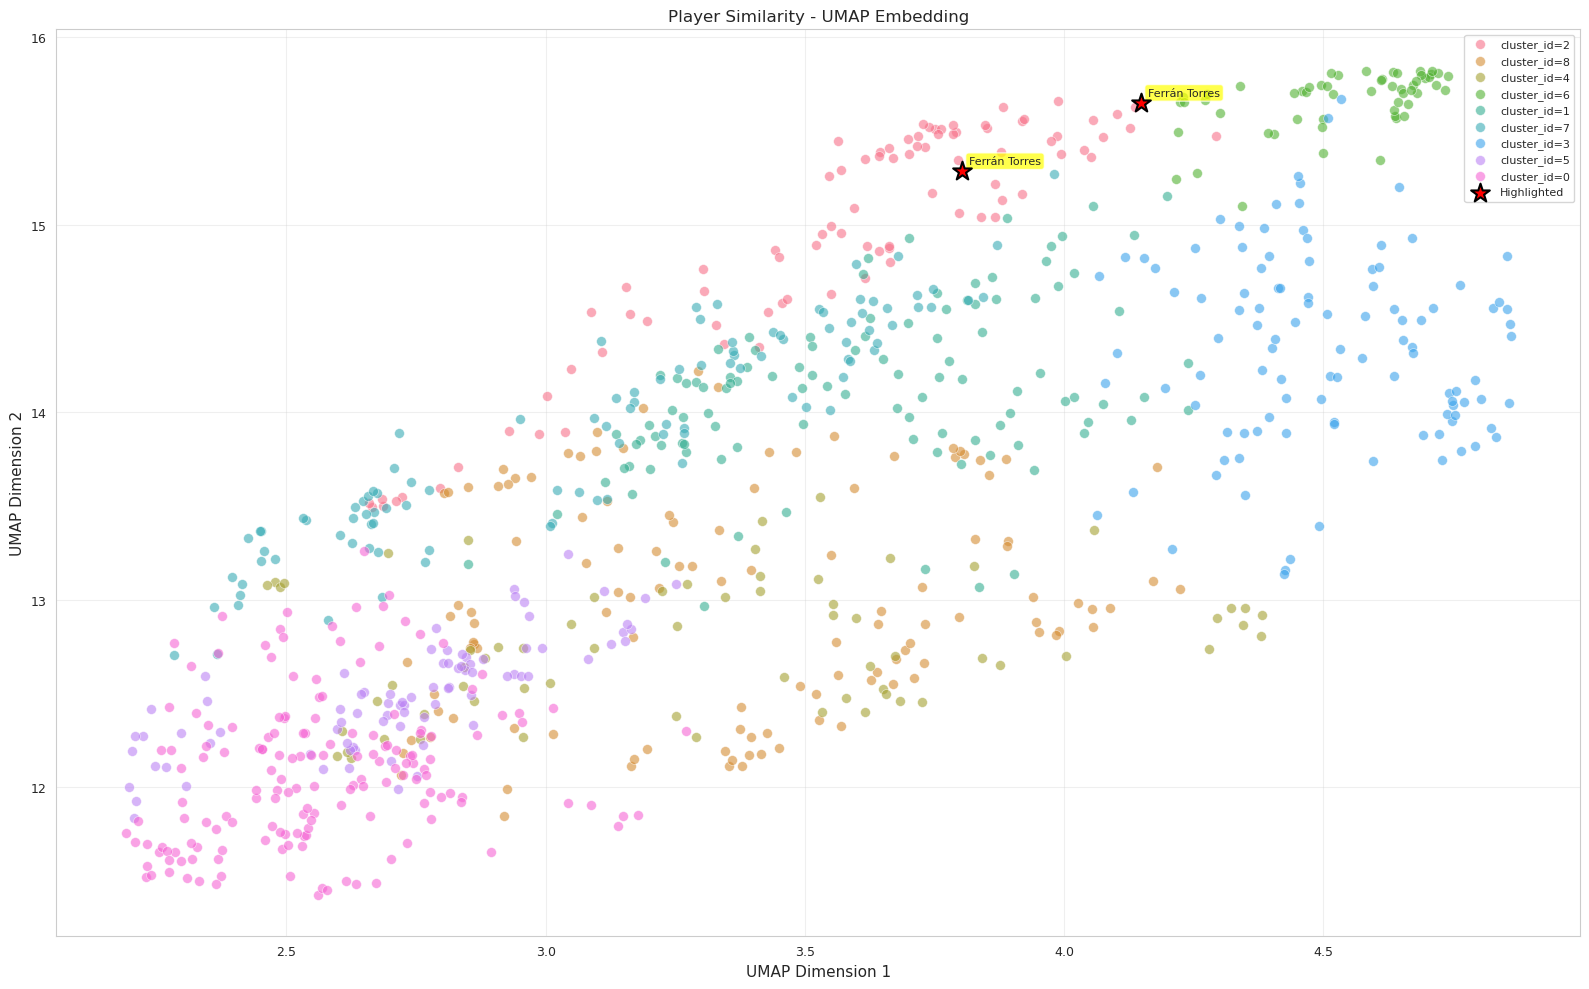


Visualizacion guardada: ferran_torres_replacement_umap.png


In [21]:
if len(ferran_2425) > 0:
    visualizer = SimilarityVisualizer(figsize=(16, 10), dpi=100)
    
    highlight_ids = [ferran_2425_id]
    if len(ferran_2526) > 0:
        highlight_ids.append(ferran_2526_id)
    
    fig = visualizer.plot_umap_embedding(
        embedding_df,
        color_by='cluster_id',
        highlight_players=highlight_ids,
        save_path='ferran_torres_replacement_umap.png',
        show=True
    )
    print("\nVisualizacion guardada: ferran_torres_replacement_umap.png")

In [22]:
if len(ferran_2425) > 0:
    results_export = pd.concat([
        similar_2425.assign(ferran_season='2024/25'),
        similar_2526.assign(ferran_season='2025/26')
    ], ignore_index=True)
    
    results_export = results_export[[
        'ferran_season', 'rank', 'player_name', 'team', 'league', 'season',
        'similarity_score', 'umap_distance', 'gmm_similarity', 'feature_similarity',
        'unique_player_id'
    ]]
    
    results_export.to_csv('ferran_torres_replacement_results.csv', index=False)
    print("\nResultados exportados a: ferran_torres_replacement_results.csv")
    print(f"Total filas exportadas: {len(results_export)}")


Resultados exportados a: ferran_torres_replacement_results.csv
Total filas exportadas: 20


In [23]:
data_prep.close_connection()
print("Analisis completado. Conexion BD cerrada.")

2025-11-20 14:58:26,381 - similarity.data_preparation - INFO - Database connection closed


Analisis completado. Conexion BD cerrada.
